In [1]:
import sys
print(sys.version)


3.10.11 (v3.10.11:7d4cc5aa85, Apr  4 2023, 19:05:19) [Clang 13.0.0 (clang-1300.0.29.30)]


In [3]:
# ---  IMPORTS ---
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

try:
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Devices: {tf.config.list_physical_devices()}")
except:
    pass

print("Libraries loaded successfully.")

TensorFlow Version: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Libraries loaded successfully.


CONFIG

In [4]:
# ---  CONFIGURATION ---

DATASET_PATH = "./data/genres_original"
CHECKPOINT_FOLDER = "./checkpoints"
MODEL_NAME = "genre_model.keras"
MAPPING_PATH = "genre_mappings.json"

os.makedirs(CHECKPOINT_FOLDER, exist_ok=True)

SAMPLE_RATE = 22050
DURATION = 30 
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
SEGMENT_DURATION = 3 
SAMPLES_PER_SEGMENT = int(SAMPLE_RATE * SEGMENT_DURATION)


OVERLAP_PERCENT = 0.5 
STEP_SIZE = int(SAMPLES_PER_SEGMENT * (1 - OVERLAP_PERCENT))

print("Configuration set.")
print(f"Dataset expected at: {os.path.abspath(DATASET_PATH)}")

Configuration set.
Dataset expected at: /Users/namanpanwar/Desktop/My_Genre_API/data/genres_original


AUGMENTATION

In [5]:
# ---  HELPER FUNCTIONS ---

def add_noise(data, noise_factor=0.005):
    """Adds white noise to simulate real-world mic static"""
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def process_segment(segment, sr, label_index, local_specs, local_labels, expected_vectors):
    """Converts audio to image (Spectrogram) and fixes size"""
    
    mel_spec = librosa.feature.melspectrogram(
        y=segment, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    if log_mel_spec.shape[1] != expected_vectors:
        if log_mel_spec.shape[1] > expected_vectors:
            log_mel_spec = log_mel_spec[:, :expected_vectors]
        else:
            log_mel_spec = np.pad(log_mel_spec, ((0,0), (0, expected_vectors - log_mel_spec.shape[1])), 'constant')

    local_specs.append(log_mel_spec)
    local_labels.append(label_index)

print("Helper functions defined.")

Helper functions defined.


PREPROCESSING

In [6]:
# ---  PREPROCESSING (SAVE TO DISK) ---

if not os.path.exists(DATASET_PATH):
    print(f"ERROR: Dataset not found at {DATASET_PATH}")
    print("Please create a 'data' folder and unzip 'genres_original' inside it.")
else:
    # Get list of genres
    genres = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
    print(f"Found Genres: {genres}")
    
    expected_vectors = int(np.ceil(SAMPLES_PER_SEGMENT / HOP_LENGTH))

    for i, genre in enumerate(genres):
        checkpoint_path = os.path.join(CHECKPOINT_FOLDER, f"{genre}.npz")
     
        if os.path.exists(checkpoint_path):
            print(f"✅ {genre} already processed. Skipping.")
            continue
            
        print(f"⏳ Processing {genre}...", end="")
        
        genre_specs = []
        genre_labels = []
        genre_dir = os.path.join(DATASET_PATH, genre)
        
        # Loop through files in this genre
        for f in os.listdir(genre_dir):
            if f.endswith((".wav", ".au", ".mp3")):
                file_path = os.path.join(genre_dir, f)
                try:
                    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                   
                    for start in range(0, len(y) - int(SAMPLES_PER_SEGMENT), STEP_SIZE):
                        finish = start + int(SAMPLES_PER_SEGMENT)
                        segment = y[start:finish]

                        if len(segment) == int(SAMPLES_PER_SEGMENT):
                           
                            process_segment(segment, sr, i, genre_specs, genre_labels, expected_vectors)
                            
                           
                            noisy = add_noise(segment)
                            process_segment(noisy, sr, i, genre_specs, genre_labels, expected_vectors)
                            
                except Exception as e:
                    pass 

        np.savez_compressed(checkpoint_path, specs=np.array(genre_specs, dtype=np.float32), labels=np.array(genre_labels, dtype=np.int32))
        print(" Done.")
        
        del genre_specs, genre_labels
        gc.collect()
        
    print("\nAll genres processed!")

Found Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
⏳ Processing blues... Done.
⏳ Processing classical... Done.
⏳ Processing country... Done.
⏳ Processing disco... Done.
⏳ Processing hiphop... Done.
⏳ Processing jazz...

/var/folders/s2/j7q69v_x64lf2lh4p16ylvhc0000gn/T/ipykernel_40987/1910802671.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/Users/namanpanwar/Desktop/My_Genre_API/.venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Done.
⏳ Processing metal... Done.
⏳ Processing pop... Done.
⏳ Processing reggae... Done.
⏳ Processing rock... Done.

All genres processed!


In [7]:
# ---  LOAD DATA ---

print("Merging data into memory...")

total_samples = 0
sample_shape = None
genres = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])

for genre in genres:
    path = os.path.join(CHECKPOINT_FOLDER, f"{genre}.npz")
    if os.path.exists(path):
        with np.load(path) as data:
            total_samples += data['labels'].shape[0]
            if sample_shape is None: sample_shape = data['specs'].shape[1:]

print(f"Total samples found: {total_samples}")

X = np.zeros((total_samples, *sample_shape), dtype=np.float32)
y = np.zeros((total_samples,), dtype=np.int32)

current_idx = 0
for genre in genres:
    path = os.path.join(CHECKPOINT_FOLDER, f"{genre}.npz")
    if os.path.exists(path):
        with np.load(path) as data:
            num = data['labels'].shape[0]
            X[current_idx : current_idx + num] = data['specs']
            y[current_idx : current_idx + num] = data['labels']
            current_idx += num

X = X[..., np.newaxis]

print(f"Data Loaded Successfully.")
print(f"Final Data Shape: {X.shape}")

Merging data into memory...
Total samples found: 37942
Data Loaded Successfully.
Final Data Shape: (37942, 128, 130, 1)


In [8]:
# ---  MODEL ARCHITECTURE ---

def build_model(input_shape):
    model = models.Sequential([
   
        layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        layers.BatchNormalization(),
        
      
        layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        layers.BatchNormalization(),
     
        layers.Conv2D(128, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, (2,2), activation='relu'),
        layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), # High dropout for robustness
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(10, activation='softmax')
    ])
    return model

print("Model architecture defined.")

Model architecture defined.


In [9]:
# ---  TRAINING ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = build_model((X_train.shape[1], X_train.shape[2], 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

print("Starting Training...")
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=70, 
                    batch_size=32,
                    callbacks=[early_stop, reduce_lr])

/Users/namanpanwar/Desktop/My_Genre_API/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-20 22:23:41.238623: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-20 22:23:41.241297: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-20 22:23:41.244545: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-20 22:23:41.245291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-20 22:23:41.246226: I tensorflow/core/common_runtime/pluggable_device/pluggabl

Starting Training...
Epoch 1/70


2025-11-20 22:23:55.587537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


759/759 ━━━━━━━━━━━━━━━━━━━━ 166s 190ms/step - accuracy: 0.3132 - loss: 6.1779 - val_accuracy: 0.5989 - val_loss: 2.1852 - learning_rate: 1.0000e-04
Epoch 2/70
759/759 ━━━━━━━━━━━━━━━━━━━━ 144s 189ms/step - accuracy: 0.4761 - loss: 5.6593 - val_accuracy: 0.7098 - val_loss: 2.1331 - learning_rate: 1.0000e-04
Epoch 3/70
759/759 ━━━━━━━━━━━━━━━━━━━━ 145s 190ms/step - accuracy: 0.5643 - loss: 4.9893 - val_accuracy: 0.7630 - val_loss: 1.8222 - learning_rate: 1.0000e-04
Epoch 4/70
759/759 ━━━━━━━━━━━━━━━━━━━━ 143s 188ms/step - accuracy: 0.6234 - loss: 4.4349 - val_accuracy: 0.7121 - val_loss: 2.7805 - learning_rate: 1.0000e-04
Epoch 5/70
759/759 ━━━━━━━━━━━━━━━━━━━━ 142s 187ms/step - accuracy: 0.6633 - loss: 3.9088 - val_accuracy: 0.7944 - val_loss: 1.7431 - learning_rate: 1.0000e-04
Epoch 6/70
759/759 ━━━━━━━━━━━━━━━━━━━━ 145s 191ms/step - accuracy: 0.7006 - loss: 3.4214 - val_accuracy: 0.7785 - val_loss: 2.1350 - learning_rate: 1.0000e-04
Epoch 7/70
759/759 ━━━━━━━━━━━━━━━━━━━━ 140s 185ms/

Model saved to genre_model.keras

Final Test Accuracy: 97.15%
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


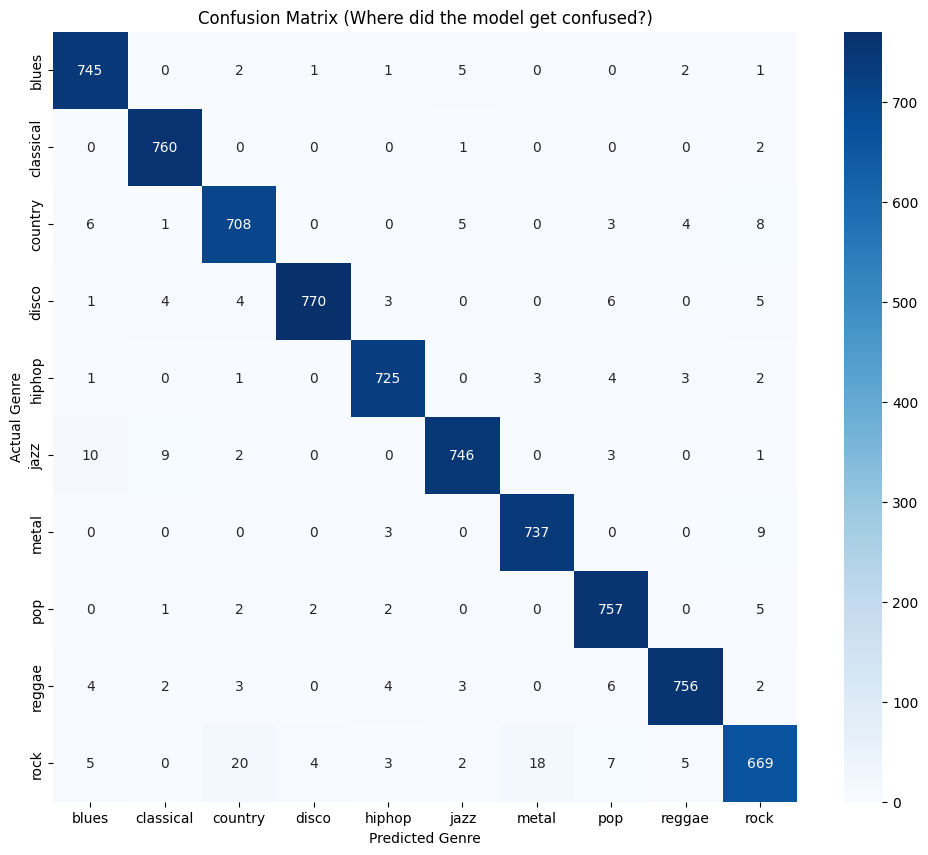

In [10]:
# ---  EVALUATION & SAVING ---

model.save(MODEL_NAME)
with open(MAPPING_PATH, "w") as fp:
    json.dump(genres, fp)
print(f"Model saved to {MODEL_NAME}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, cmap='Blues')
plt.xlabel('Predicted Genre')
plt.ylabel('Actual Genre')
plt.title('Confusion Matrix (Where did the model get confused?)')
plt.show()